In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import glob
from matplotlib.colors import Normalize

from matplotlib.colors import LogNorm

In [12]:
# === Defina aqui manualmente seus arquivos ===
# eye_files = {
#     (0, 1): "scan_00006A_from_slot1--_-slot2--_-slot3--__to_slot0_Quad_131_MGT_X0Y18_TX-_Quad_131_MGT_X0Y18_RX.csv",
#     (0, 2): "scan_00006A_from_slot1--_-slot2--_-slot3--__to_slot0_Quad_131_MGT_X0Y16_TX-_Quad_131_MGT_X0Y16_RX.csv",
#     (0, 3): "scan_00006A_from_slot1--_-slot2--_-slot3--__to_slot0_Quad_130_MGT_X0Y14_TX-_Quad_130_MGT_X0Y14_RX.csv",
#     (1, 0): "scan_00010A_from_slot0--_-slot2--_-slot3--__to_slot1_Quad_131_MGT_X0Y18_TX-_Quad_131_MGT_X0Y18_RX.csv",
#     (1, 2): "scan_00010A_from_slot0--_-slot2--_-slot3--__to_slot1_Quad_131_MGT_X0Y16_TX-_Quad_131_MGT_X0Y16_RX.csv",
#     (1, 3): "scan_00010A_from_slot0--_-slot2--_-slot3--__to_slot1_Quad_130_MGT_X0Y14_TX-_Quad_130_MGT_X0Y14_RX.csv",
#     (2, 0): "scan_00038A_from_slot0--_-slot1--_-slot3--__to_slot2_Quad_131_MGT_X0Y18_TX-_Quad_131_MGT_X0Y18_RX.csv",
#     (2, 1): "scan_00038A_from_slot0--_-slot1--_-slot3--__to_slot2_Quad_131_MGT_X0Y16_TX-_Quad_131_MGT_X0Y16_RX.csv",
#     (2, 3): "scan_00038A_from_slot0--_-slot1--_-slot3--__to_slot2_Quad_130_MGT_X0Y14_TX-_Quad_130_MGT_X0Y14_RX.csv",
#     (3, 0): "scan_00018A_from_slot0--_-slot1--_-slot2--__to_slot3_Quad_131_MGT_X0Y18_TX-_Quad_131_MGT_X0Y18_RX.csv",
#     (3, 1): "scan_00018A_from_slot0--_-slot1--_-slot2--__to_slot3_Quad_131_MGT_X0Y16_TX-_Quad_131_MGT_X0Y16_RX.csv",
#     (3, 2): "scan_00018A_from_slot0--_-slot1--_-slot2--__to_slot3_Quad_130_MGT_X0Y14_TX-_Quad_130_MGT_X0Y14_RX.csv",
# }

eye_files = {
    (0, 1): "scan_00010A_from_slot1--_-slot2--_-slot3--__to_slot0_Quad_131_MGT_X0Y18_TX-_Quad_131_MGT_X0Y18_RX.csv",
    (0, 2): "scan_00010A_from_slot1--_-slot2--_-slot3--__to_slot0_Quad_131_MGT_X0Y16_TX-_Quad_131_MGT_X0Y16_RX.csv",
    (0, 3): "scan_00010A_from_slot1--_-slot2--_-slot3--__to_slot0_Quad_130_MGT_X0Y14_TX-_Quad_130_MGT_X0Y14_RX.csv",
    (1, 0): "scan_00018A_from_slot0--_-slot2--_-slot3--__to_slot1_Quad_131_MGT_X0Y18_TX-_Quad_131_MGT_X0Y18_RX.csv",
    (1, 2): "scan_00018A_from_slot0--_-slot2--_-slot3--__to_slot1_Quad_131_MGT_X0Y16_TX-_Quad_131_MGT_X0Y16_RX.csv",
    (1, 3): "scan_00018A_from_slot0--_-slot2--_-slot3--__to_slot1_Quad_130_MGT_X0Y14_TX-_Quad_130_MGT_X0Y14_RX.csv",
    (2, 0): "scan_00038A_from_slot0--_-slot1--_-slot3--__to_slot2_Quad_131_MGT_X0Y18_TX-_Quad_131_MGT_X0Y18_RX.csv",
    (2, 1): "scan_00038A_from_slot0--_-slot1--_-slot3--__to_slot2_Quad_131_MGT_X0Y16_TX-_Quad_131_MGT_X0Y16_RX.csv",
    (2, 3): "scan_00038A_from_slot0--_-slot1--_-slot3--__to_slot2_Quad_130_MGT_X0Y14_TX-_Quad_130_MGT_X0Y14_RX.csv",
    (3, 0): "scan_000040A_from_slot0--_-slot1--_-slot2--__to_slot3_Quad_131_MGT_X0Y18_TX-_Quad_131_MGT_X0Y18_RX.csv",
    (3, 1): "scan_000040A_from_slot0--_-slot1--_-slot2--__to_slot3_Quad_131_MGT_X0Y16_TX-_Quad_131_MGT_X0Y16_RX.csv",
    (3, 2): "scan_000040A_from_slot0--_-slot1--_-slot2--__to_slot3_Quad_130_MGT_X0Y14_TX-_Quad_130_MGT_X0Y14_RX.csv",
}


In [13]:
# === Função para ler e processar o CSV da Vivado ===
def load_eye_data(filename):
    with open(filename, "r") as f:
        lines = f.readlines()
    start = next(i for i, line in enumerate(lines) if "2d statistical" in line)
    header = lines[start].strip().split(",")[1:]
    data_lines = []
    for line in lines[start+1:]:
        if "Scan End" in line:
            break
        data_lines.append(line.strip().split(","))
    df = pd.DataFrame(data_lines)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(inplace=True)
    df.columns = ["Y"] + header
    df["Y"] = df["Y"].astype(float)
    df.set_index("Y", inplace=True)
    return df.columns.astype(float), df.index.values, df.values

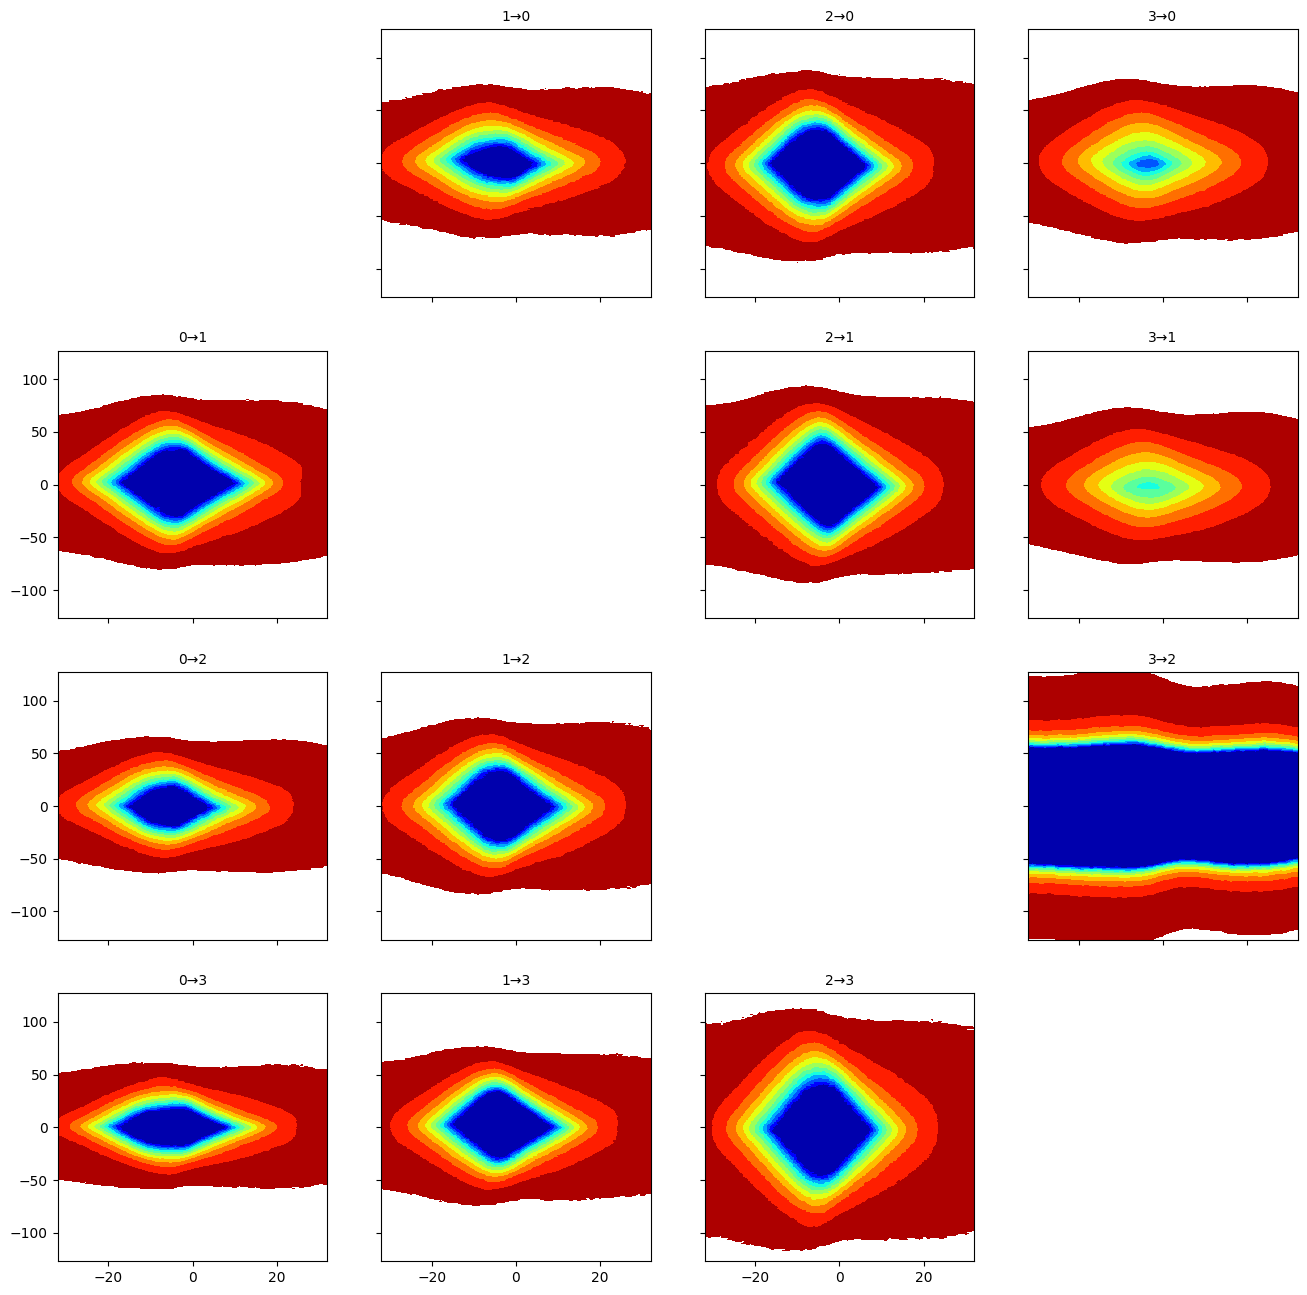

In [14]:
# === Geração dos subplots ===
fig, axes = plt.subplots(4, 4, figsize=(16, 16), sharex=True, sharey=True)
levels = np.linspace(0, 0.45, 12)  # Ajuste se necessário
cmap = "viridis"


for from_slot in range(4):
    for to_slot in range(4):
        ax = axes[from_slot, to_slot]
        if from_slot == to_slot:
            ax.axis("off")
            continue
        file = eye_files.get((from_slot, to_slot))
        if file:
            try:
                x, y, z = load_eye_data(file)
                X, Y = np.meshgrid(x, y)
                #vmin = np.percentile(z, 5)   # 5º percentil
                #vmax = np.percentile(z, 95)  # 95º percentil
                vmin = 1.9e-7   # BER mínimo mostrado na barra
                vmax = 2.9e-1   # BER máximo mostrado na barra
                levels = np.logspace(np.log10(vmin), np.log10(vmax), num=13)
                #cs = ax.contourf(x, y, z, levels=levels, cmap="jet")
                cs = ax.contourf(X, Y, z, levels=levels, cmap="jet", norm=LogNorm(vmin=vmin, vmax=vmax))
                ax.set_title(f"{to_slot}→{from_slot}", fontsize=10)
                #cbar = plt.colorbar(contour, format="%.1e", ticks=levels)
                #cbar.ax.set_yticklabels(["{:.1e}".format(lvl) for lvl in levels])
                #cbar.set_label("BER", fontsize=12)
            except Exception as e:
                ax.set_title("Erro", color="red")
                print(f"Erro ao carregar {file}: {e}")
        else:
            ax.axis("off")



In [5]:
# Ajustes finais
fig.suptitle("Eye Diagrams (from_slot → to_slot)", fontsize=16)
cbar = fig.colorbar(cs, ax=axes, orientation='vertical', fraction=0.015, pad=0.01)
cbar.set_label("BER Estimate")
plt.tight_layout(rect=[0, 0, 0.96, 0.96])
plt.show()

<Figure size 640x480 with 0 Axes>

C:\Users\Cosmology Lab\AppData\Local\Temp\ipykernel_52728\1319878194.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Deixa espaço para a colorbar


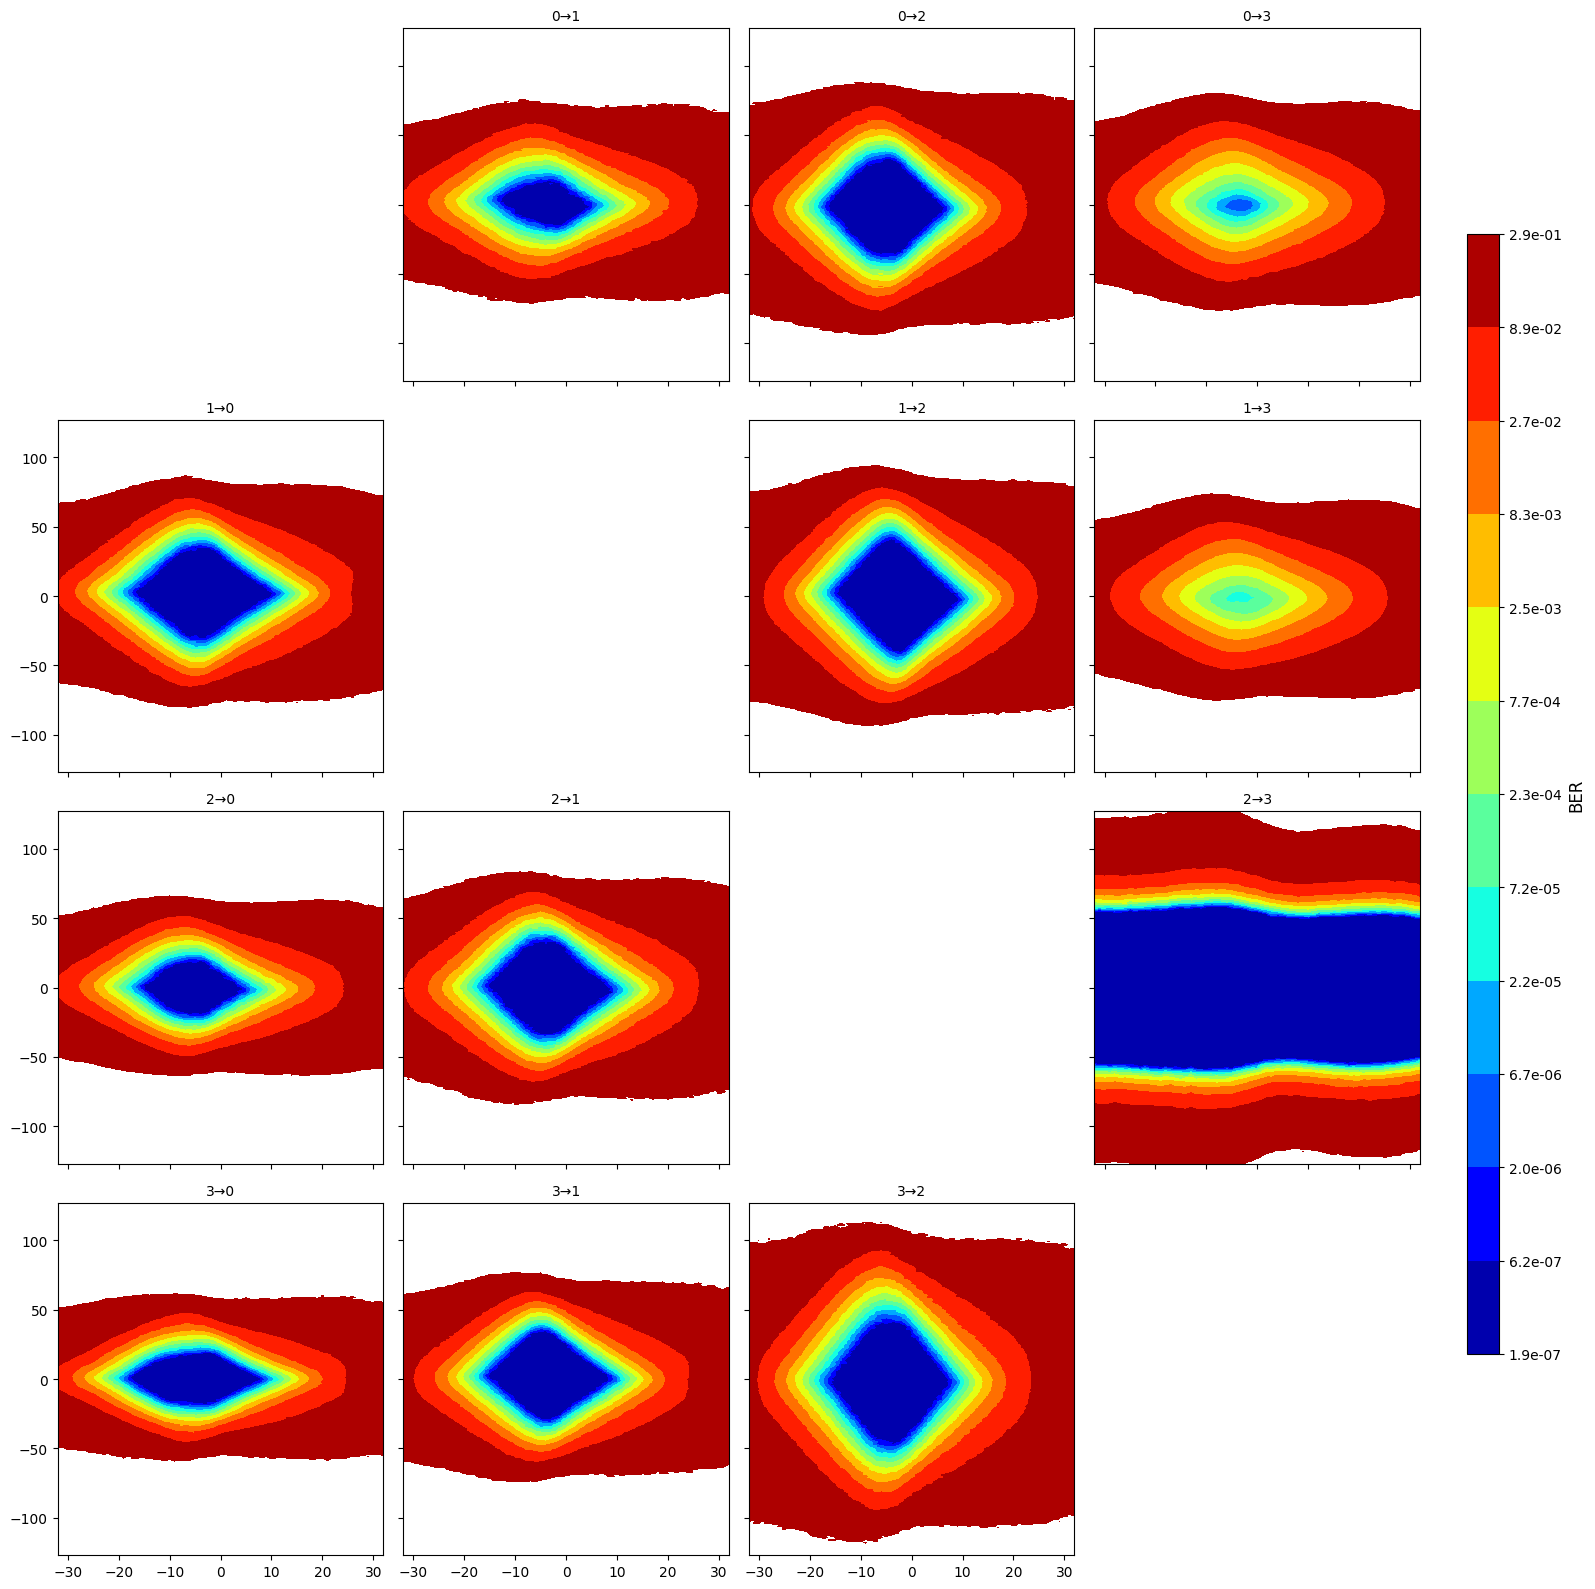

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

# === Geração dos subplots ===
fig, axes = plt.subplots(4, 4, figsize=(16, 16), sharex=True, sharey=True)
levels = np.logspace(np.log10(1.9e-7), np.log10(2.9e-1), num=13)
cmap = "jet"
norm = LogNorm(vmin=1.9e-7, vmax=2.9e-1)
contour_plots = []

for from_slot in range(4):
    for to_slot in range(4):
        ax = axes[from_slot, to_slot]
        if from_slot == to_slot:
            ax.axis("off")
            continue
        file = eye_files.get((from_slot, to_slot))
        if file:
            try:
                x, y, z = load_eye_data(file)
                X, Y = np.meshgrid(x, y)
                cs = ax.contourf(X, Y, z, levels=levels, cmap=cmap, norm=norm)
                contour_plots.append(cs)
                ax.set_title(f"{from_slot}→{to_slot}", fontsize=10)
            except Exception as e:
                ax.set_title("Erro", color="red")
                print(f"Erro ao carregar {file}: {e}")
        else:
            ax.axis("off")

# === Adiciona uma barra lateral global ===
# Define a posição para a barra lateral à direita da figura
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]

# Usa o último contour para criar a barra lateral (todos usam o mesmo levels/norm)
cbar = fig.colorbar(contour_plots[-1], cax=cbar_ax, ticks=levels, format="%.1e")
cbar.ax.set_yticklabels(["{:.1e}".format(lvl) for lvl in levels])
cbar.set_label("BER", fontsize=12)

fig.savefig("eye_matrix.jpg", dpi=300, bbox_inches='tight')

# Layout ajustado
#fig.suptitle("Matriz de Diagramas de Olho (BER)", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Deixa espaço para a colorbar
plt.show()


#fig.savefig("eye_matrix.svg", bbox_inches='tight')